# <span style="color:#9689d6">ADA - Class Project - P3 deliverable</span>

## Team: Les Fraises TagADA
    Barghorn Jérémy
    Friedrich Claire    
    Gotti Bryan
    Petit-Phar Oriane
    Schifferli Théo 
    

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from src.scripts.article_to_country import *
from src.data.dataloader import *
from src.utils.plots import *
from src.utils.functions import *
from src.scripts.graphs import *


from itertools import combinations

import plotly.express as px
from ast import literal_eval


import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [3]:
project_path = os.getcwd()
project_path

'c:\\Users\\brygo\\Documents\\ada-2024-project-lesfraisestagada'

0. Introduction
1. Country classification analysis
2. Analysis of the Wikipedia graph 
3. Analysing Dead-Ends in Wikispeedia
4. Naïve analysis of players click count (Players' Behavior Before Balancing)
5. Accounting for the influence of the graph structure

# 0. Introduction
Below you will finde the code to create the two figures presented in the introduction of the data story. The first one is based on the data from [Scimago Journal and Country Rank (SJR)](https://www.scimagojr.com/countryrank.php?year=2007), while the second one is based on our own assignment of articles to different countries, which is explained in details in part 1.

In [4]:
publications_per_country = load_publications_dataframe()
fig = plot_color_map(
    publications_per_country,
    'Publications',
)

fig.write_html("./graphs/intro/publications_intro_map.html")
fig.show()

In [5]:
articles = pd.read_csv("data/country_clicks_links.csv", index_col=0).reset_index().rename(columns={'index': 'Articles', 'Top_1_name': 'country'})
articles_per_country = articles[['country', 'Articles']].groupby('country', as_index=False).count()
fig = plot_color_map(
    articles_per_country,
    'Articles',
)

fig.write_html("./graphs/intro/articles_intro_map.html")
fig.show()

# 1. Country classification Analysis

</div><div class="alert alert-success"> <strong>First glance at the distribution of knowledge worldwide :</strong> 

- Assign a country to each article
- Try different methods and see how many articles can be classified
- Verify these classification with human annotation 
- Select the best method for further analysis of the dataset
</div>

</div> <div class="alert alert-warning">  <strong>Countries :</strong>

In order to classify countries we used the standar ISO list with 249 countries and the following distribution: 
- UN Members: 193
- UN Observer States: 2
- States With Partial Recognition: 2
- Inhabited Dependent Territories: 45
- Uninhabited Territories: 6
- Antarctica: 1
</div>

A naïve method was employed to classify articles to specific countries by performing a text search to identify occurrences of country names within the plaintext. This approach utilized basic regular expression matching to analyze the articles. However, it resulted in approximately 31% of the articles (1,412 out of 4,604) remaining unclassified, highlighting significant limitations.

### Identified Issues with the Approach:
1. **Over-classification on mentioned country names**: 
   The presence of a country name in an article does not necessarily imply that the article belongs to that country. This assumption leads to inaccuracies in classification.

2. **Lack of contextual understanding**: 
   The text search method lacks the ability to discern the context in which a country name appears, resulting in potential misclassifications.

3. **Observations**: 
   A review of the articles revealed a lot of incorrect or missing classifications. For example:
   - The article *13th Century* was missclassified under China due to mentions of events occurring there during that period, despite the article lacking any specific association with China.
   - Conversely, the article *4-2-0*, which details a type of railroad in the United States, was left unclassified despite its clear appartenance to that country.

These findings show the limitations of the current text-matching methodology and highlight the need for a more robust, context-aware approach to accurately classify articles.

Given the limitations of the initial text-search-based approach, a decision was made to use Large Language Models (LLMs) to enhance the article classification process. LLMs, with their extensive general knowledge, have the capability to analyze articles and respond to queries with a deeper understanding. 

Unlike simple text searches, LLMs not only utilize the content of the article but also incorporate their pre-existing (trained) knowledge. This contextual understanding should enables more accurate classification.

By employing LLMs, two potential strategies can be pursued:
1. **Targeted classification of previously unclassified articles**: The 1,412 articles that remained unclassified under the initial approach can be reevaluated, allowing for a significant reduction in the unclassified proportion. After this step only 6% (283 out of 4604) were not classified.

2. **Full Reclassification**: LLMs can be used to perform a complete reclassification of all articles, eliminating the biases and limitations inherent in the original text-search methodology. In order to test this two existing LLMs were used : [LLaMa](https://www.llama.com/) and [Qwen](https://qwen-ai.com/). These powerful models, with less than 8 billion parameters, offer significant computational efficiency and can be run locally on consumer hardware, making them accessible and cost-effective solutions compared to bigger models like ChatGPT and their paid API.

This transition to LLM-based classification is expected to significantly improve the accuracy and reliability of the country assignment process.

The prompt used in order to make the models classify the articles was the following : 

```
You will be given textual articles. For each article provide a single and unique country to which the article is related and should be classified to. Provide the answer in the form : country.
If there is no country related to the article, please write 'None'. 
If the location is not on earth, please write 'None'. 
If the article is a general article where the content is not specifically related to a country, please write 'None'.
You must be 100\% sure this is a question of life.
This is the list of coutnries that you are allowed to output don't output anything that is not in this list: {countries}
```

To test the accuracy of the model’s predictions compared to human judgment, each member of the group manually annotated 20 articles, with a 10-article overlap between annotators. As a result, each article was annotated by two members, yielding a total of 50 annotations. Among these, 36 annotations matched, resulting in an inter-annotator agreement of 72%. This annotated subset was used as a benchmark to evaluate various classification methods and establish an agreement metric.

The highest agreement with human annotations (72%) was achieved using the "Full Classification with LLaMa." However, a review of the assignments revealed that an excessively high number of articles (90%) were being classified, leading to potential overclassification. Some articles were misclassified because the system prompt provided the model with a list of all countries. This introduced a bias, leading the model to disproportionately classify articles under Afghanistan, as it appears first alphabetically in the list.

To address this, the system prompt was iteratively refined to enhance agreement accuracy. After achieving improved agreement values, the refined prompt was used to reclassify the entire dataset. In order to remove the biases due to the ordering of countries in the list the classification was run 2 times with two different orders and then only the matching assignments were kept.

The improved prompt is : 

```
You will be given textual articles. For each article provide a single and unique country to which the article is related and should be classified to. Provide the answer in the form : country. 
If the article is related to an object, a place, a monument related to a country, please write the country.
if the article is about a spieces, that lives in multiple countries, please write 'None'.
If there is no country related to the article, please write 'None'. 
If the location is not on earth, please write 'None'. 
If the article is a general article where the content is not specifically related to a country, please write 'None'.
You are allowed to use the article name to help you find the country.
This is the list of coutnries that you are allowed to output don't output anything that is not in this list: {countries}
```

This refinement resulted in an improved agreement value of 78%% while reducing the proportion of classified articles to 56%, addressing the issue of overclassification. This proportion of classified articles matches our expectations and is possibly still a bit high since in our annotation 41% of articles were not classified.
This final classification is then used for the whole project.

### Downsides and limitations : 
- **Limited number of annotated articles** : The analysis was based on a relatively small sample of 36 annotated articles, which may result in imprecise agreement values. To improve the accuracy and reliability of the findings, a larger dataset of annotated articles would be necessary. However, due to time constraints, expanding the dataset or engaging additional human annotators was not feasible.
- **Small size of LLM** : The model used in this study was relatively small, which inherently limits its knowledge and performance. While larger language models are expected to perform better on such tasks, the decision to prioritize local execution and cost-effectiveness constrained the use of more powerful models.

### Below you will find the code showing how the annotation was done and how the plots were generated

For more detailed informations about how the classifications were done please refer to the script ```article_to_country.py```

In [5]:
results = {}
country_data = pd.read_csv('data/country_data.csv', index_col=0)
counts = filter_top_k(country_data, k=2, N=1)
total_number_of_articles = len(counts)

nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")
results["Text search"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles * 100

refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with naive + llama: {len(nan_df)}")
results["Text search + missing articles classified with LlaMa"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles * 100

qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
qwen_missing = len(qwen_country_data[qwen_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with Qwen: {qwen_missing}")
results["Full classification with Qwen"] = (total_number_of_articles - qwen_missing) / total_number_of_articles * 100


llama_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
llama_missing = len(llama_country_data[llama_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing}")
results["Full classification with LLaMa"] = (total_number_of_articles - llama_missing) / total_number_of_articles * 100

llama_country_data_imporved_normal = pd.read_csv('data/country_data_full_llama_improved_normal.csv', index_col=0)
llama_country_data_imporved_reversed = pd.read_csv('data/country_data_full_llama_improved_reversed.csv', index_col=0)

llama_country_data_imporved = pd.read_csv('data/country_data_full_llama_improved_reversed.csv', index_col=0)

llama_country_data_imporved_normal["Top_1_name"] = llama_country_data_imporved_normal["Top_1_name"].where(llama_country_data_imporved_normal['Top_1_name'] == llama_country_data_imporved_reversed['Top_1_name'], np.nan)
llama_country_data_imporved = llama_country_data_imporved_normal
llama_missing_improved = len(llama_country_data_imporved[llama_country_data_imporved["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing_improved}")
results["Improved classification with LLaMa"] = (total_number_of_articles - llama_missing_improved) / total_number_of_articles * 100
llama_country_data_imporved.drop(columns=["Predictions"], inplace=True)
llama_country_data_imporved.to_csv('data/country_data_full_llama_improved.csv')


Number of articles with no countries before completion with llama: 1412
Number of articles with no countries after completion with naive + llama: 283
Number of articles with no countries after completion with Qwen: 2905
Number of articles with no countries after completion with LLAMA: 479
Number of articles with no countries after completion with LLAMA: 2010


In [6]:
fig = px.bar(x=results.keys(), y=results.values(), color=results.keys(), labels={"x": "Classification Method", "y": "% of articles assigned to a country"})
# fig.update_layout(title="Proportion of articles assigned to a country") #legend is not shown since we want to write it directly on the website in HTML for better readability
fig.update_xaxes(showticklabels=False)  # Remove x-axis tick labels
fig.update_yaxes(range=[0, 100])
fig.show()
fig.write_html("./graphs/proportion_country_assignment.html")

In [7]:
import plotly.express as px
import pandas as pd
from itertools import combinations

# Data preparation (same as yours)
models = {
    "Text search": counts,
    "Text search + missing articles classified with LlaMa": refined_data,
    "Full classification with Qwen": qwen_country_data,
    "Full classification with LLaMa": llama_country_data,
    "Improved classification with LLaMa": llama_country_data_imporved
}

heatmap_data = pd.DataFrame(index=models.keys(), columns=models.keys())

for model in models.keys():
    heatmap_data.loc[model, model] = 1.0

for model1, model2 in combinations(models.keys(), 2):
    df_1 = models[model1]
    df_2 = models[model2]
    overlap = (df_1["Top_1_name"] == df_2["Top_1_name"]).sum() / total_number_of_articles
    heatmap_data.loc[model2, model1] = overlap.round(2)

heatmap_data = heatmap_data.astype(float)

# Replace row and column names with indices
model_names = list(models.keys())
index_to_name = {i: name for i, name in enumerate(model_names)}  # Create legend mapping

# Create heatmap with indices
heatmap_data.index = range(len(model_names))
heatmap_data.columns = range(len(model_names))

# Generate the heatmap
fig = px.imshow(
    heatmap_data.values,
    labels={"x": "Index", "y": "Index", "color": "Overlap"},
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale="Blues",
    text_auto=True,
)

fig.update_layout(
    title="Overlap Between Classification Methods",
    xaxis_title="Classification Method Index",
    yaxis_title="Classification Method Index",
    coloraxis_colorbar=dict(title="Overlap"),
)

fig.update_xaxes(dtick=1)  # Force x-axis to show every tick
fig.update_yaxes(dtick=1)  # Force y-axis to show every tick
fig.update_layout(coloraxis_showscale=False)  # Hide the color scale

# Display legend associating indices to model names
legend_text = "<br>".join([f"{i}: {name}" for i, name in index_to_name.items()])
fig.add_annotation(
    text=f"<b>Legend:</b><br>{legend_text}",
    xref="paper", yref="paper",
    x=0.0, y=0.5,
    showarrow=False,
    align="left",
    font=dict(size=12)
)

fig.show()
# fig.write_html("./graphs/overlap_heatmap.html")


In [8]:
articles = pd.DataFrame(counts.index)

subset_1 = articles.sample(10, random_state=0).values.flatten().tolist()
subset_2 = articles.sample(10, random_state=1).values.flatten().tolist()
subset_3 = articles.sample(10, random_state=2).values.flatten().tolist()
subset_4 = articles.sample(10, random_state=3).values.flatten().tolist()
subset_5 = articles.sample(10, random_state=4).values.flatten().tolist()
subset_6 = articles.sample(10, random_state=5).values.flatten().tolist()

claire = subset_1 + subset_3
theo = subset_2 + subset_4
oriane = subset_1 + subset_4
bryan = subset_2 + subset_5
jeremy = subset_3 + subset_5

claire = pd.DataFrame(index=claire, columns=["country"])
theo = pd.DataFrame(index=theo, columns=["country"])
oriane = pd.DataFrame(index=oriane, columns=["country"])
bryan= pd.DataFrame(index=bryan, columns=["country"])
jeremy = pd.DataFrame(index=jeremy, columns=["country"])

# pd.DataFrame(claire).to_csv("claire.csv")
# pd.DataFrame(theo).to_csv("theo.csv")
# pd.DataFrame(oriane).to_csv("oriane.csv")
# pd.DataFrame(bryan).to_csv("bryan.csv")
# pd.DataFrame(jeremy).to_csv("jeremy.csv")

# countries = list(dict(countries_for_language('en')).values())
# pd.DataFrame(countries).to_csv("countries.csv")

annotation_path = "./data/annotated/"

claire = pd.read_csv(annotation_path + "subset_claire.csv", index_col=0, na_values="None")
theo = pd.read_csv(annotation_path + "subset_theo.csv", index_col=0, na_values="None")
oriane = pd.read_csv(annotation_path + "subset_oriane.csv", index_col=0, na_values="None")
bryan = pd.read_csv(annotation_path + "subset_bryan.csv", index_col=0, na_values="None")
jeremy = pd.read_csv(annotation_path + "subset_jeremy.csv", index_col=0, na_values="None")

subset_1_c = claire[:10]
subset_3_c = claire[10:]

subset_2_t = theo[:10]
subset_4_t = theo[10:]

subset_1_o = oriane[:10]
subset_4_o = oriane[10:]

subset_2_b = bryan[:10]
subset_5_b = bryan[10:]

subset_3_j = jeremy[:10]
subset_5_j = jeremy[10:]

comparison1 = subset_1_c["country"].str.lower().fillna("nan") == subset_1_o["country"].str.lower().fillna("nan")
print(f"Agreement between Claire and Oriane: {comparison1.sum() * 10}%")
comparison2 = subset_2_t["country"].str.lower().fillna("nan") == subset_2_b["country"].str.lower().fillna("nan")
print(f"Agreement between Theo and Bryan: {comparison2.sum() * 10}%")
comparison3 = subset_3_c["country"].str.lower().fillna("nan") == subset_3_j["country"].str.lower().fillna("nan")
print(f"Agreement between Claire and Jeremy: {comparison3.sum() * 10}%")
comparison4 = subset_4_t["country"].str.lower().fillna("nan") == subset_4_o["country"].str.lower().fillna("nan")
print(f"Agreement between Theo and Oriane: {comparison4.sum() * 10}%")
comparison5 = subset_5_b["country"].str.lower().fillna("nan") == subset_5_j["country"].str.lower().fillna("nan")
print(f"Agreement between Bryan and Jeremy: {comparison5.sum() * 10}%")

df = pd.concat([
    subset_1_c.loc[comparison1],
    subset_2_b.loc[comparison2],
    subset_3_c.loc[comparison3],
    subset_4_t.loc[comparison4],
    subset_5_b.loc[comparison5]
], ignore_index=False)

df.to_csv("data/annotated/consensus.csv")
llama_country_data_imporved.loc[df.index]["Top_1_name"].str.lower().fillna("nan")

Agreement between Claire and Oriane: 80%
Agreement between Theo and Bryan: 60%
Agreement between Claire and Jeremy: 80%
Agreement between Theo and Oriane: 50%
Agreement between Bryan and Jeremy: 90%


Hadrian%27s_Wall                                    nan
Globe_Theatre                                       nan
List_of_monarchs_in_the_British_Isles    united kingdom
Aleksandr_Vasilevsky                             russia
Pyongyang                                   north korea
Ivory                                               nan
Beep_%28SWBLW%29                          united states
Fermium                                             nan
Dwight_D._Eisenhower                                nan
Invasion                                        grenada
Scooby-Doo                                united states
Bill_Clinton                              united states
Frederick_Douglass                        united states
Cambrian_explosion                                china
CPU_cache                                           nan
Cathedral_of_Magdeburg                          germany
Anna_Karenina                                    russia
Eurasian_Bullfinch                              

In [9]:
models = {
    "Text search": counts,
    "Text search + missing articles classified with LlaMa": refined_data,
    "Full classification with Qwen": qwen_country_data,
    "Full classification with LLaMa": llama_country_data,
    "Improved classification with LLaMa": llama_country_data_imporved
}

values = []
for model in models.keys():
    agreement_value = (models[model].loc[df.index]["Top_1_name"].str.lower().fillna("nan") == df["country"].str.lower().fillna("nan")).sum() / len(df) * 100
    values.append(agreement_value)
    
fig = px.bar(
    x=models.keys(), 
    y=values, 
    color=models.keys(),
    title="Agreement between annotators and classification method in %", 
    labels={"x": "Classification Method", "y": "Agreement value in %"}
    )
fig.update_xaxes(showticklabels=False)  # Remove x-axis tick labels

fig.update_yaxes(range=[0, 100])
fig.show()

# fig.write_html("./graphs/agreement_bar_plot.html")

# 2. Analysis of the Wikipedia graph

## Questions of interest 

0) What are the most clicked articles?
1) What is the distribution of countries in the Wikipedia graph? 
3) What is the distribution of in and out degrees per country? 

## 2.0. What are the most clicked articles? 

Let's first import the data `country_clicks_links.csv` with which we will be working.

In [86]:
data = pd.read_csv("data/country_clicks_links.csv", index_col=0)

Now we define the variables that we need.

In [87]:
data_sorted = data.sort_values(by='click_count', ascending=False)
data_sorted = data_sorted[data_sorted['click_count'] != 0]

articles = data_sorted.index.tolist()
click_count = data_sorted.click_count.tolist()
in_degree = data_sorted.num_links_in.tolist()
out_degree = data_sorted.num_links_out.tolist()

Let's construct a graph in which: 
- each node is an article
    - 20 most clicked articles 
    - 20 least clicked articles 

In [88]:
data_top20 = data_sorted.iloc[:20,]
data_bottom20 = data_sorted.iloc[-20:,]

- the size and color of a node is proportional to the number of clicks associtated to that node
- each edge represents an out link

We are also interested in the in and out degree of each article
- in degree = num_links_in 
- out degree = num_links_out

Let's first look at the most clicked articles:

In [90]:
draw_circle_graph(data_top20, "graphs/topic_1/most_used_articles_graph.html", project_path)

graphs/topic_1/most_used_articles_graph.html
Map is saved in graphs/topic_1/most_used_articles_graph.html!


An now let's look at the least clicked articles: 

In [14]:
draw_circle_graph(data_bottom20, "graphs/topic_1/least_used_articles_graph.html", project_path)

graphs/topic_1/least_used_articles_graph.html
Map is saved in graphs/topic_1/least_used_articles_graph.html!


We see that almost all atricles among the top20 can be associated to a country (e.g. English_language to England). The same is true for the bottom20 articles (e.g. Afghan hound to Afghanistan). This motivates our project in which we will associate each article to it's corresponding country and analyse the distributions of those countries within the Wikipedia graph. In the end, we are ultimately interested in whether players of the Wikispeedia game really tend to click more on articles that are associated with western countries or if this feature is due to the properties of the Wikipedia graph itself. 

## 2.1. What is the distribution of countries in the Wikipedia graph?

Now that all (most) articles are associated to a country, we can look at the distribution of those countries. Is there a country that is associated to more articles? (we have our little idea haha but let's check). 

In order to find the distribution of countries in the Wikipedia graph, we need the number of articles that are associated to each of the represented countries.

In [15]:
countries_occurrences = data.groupby("Top_1_name").size().reset_index()
data_countries = data.groupby("Top_1_name").sum().reset_index()
data_countries["occurrence"] = countries_occurrences.iloc[:,1].tolist()

# percent of articles that belong to each country
data_countries["percent"] = data_countries["occurrence"] / sum(data_countries["occurrence"])
data_countries

,Top_1_name,click_count,num_links_in,name_links_in,num_links_out,name_links_out,occurrence,percent
0,afghanistan,629,313.0,"['15th_Marine_Expeditionary_Unit', '18th_centu...",732.0,"['18th_century', 'Afghan_Hound', 'Alexander_th...",10,0.003858
1,albania,21,85.0,"['AK-47', 'Armenia', 'Atheism', 'Athens', 'Aze...",153.0,"['Afghanistan', 'Agriculture', 'Algeria', 'Anc...",2,0.000772
2,algeria,700,263.0,"['10th_century', '1973_oil_crisis', 'Africa', ...",201.0,"['Africa', 'Agriculture', 'Algerian_Civil_War'...",6,0.002315
3,andorra,6,41.0,"['Albania', 'Armenia', 'Azerbaijan', 'Biodiver...",54.0,"['Agriculture', 'Algeria', 'Argentina', 'Brazi...",1,0.000386
4,angola,28,80.0,"['13th_century', '2005_Lake_Tanganyika_earthqu...",21.0,"['Africa', 'Atlantic_Ocean', 'Bantu', 'Cold_Wa...",1,0.000386
...,...,...,...,...,...,...,...,...
190,venezuela,447,180.0,"['El_Hatillo_Municipality%2C_Miranda', 'Global...",150.0,"['Baroque', 'Baseball', 'Capital', 'Caribbean_...",5,0.001929
191,vietnam,287,281.0,"['Asia', 'Beijing', 'Global_city', 'Ho_Chi_Min...",171.0,"['Agriculture', 'Australia', 'Capital', 'Confu...",6,0.002315
192,yemen,19,68.0,"['Albania', 'Arab_League', 'Arabic_language', ...",140.0,"['11th_century', '16th_century', '19th_century...",1,0.000386
193,zambia,121,122.0,"['Zambezi']['Africa', 'Henry_Morton_Stanley', ...",206.0,"['AIDS', 'Copper', 'Mining', 'Zambezi', 'Zambi...",6,0.002315


In [16]:
data_countries['custom_text'] = (
    "Country: " + data_countries['Top_1_name'] +
    "<br>Percentage: " + round(data_countries['percent'] * 100, 2).astype(str) + "%"
)

fig = px.pie(data_countries, values='percent', names='Top_1_name')
fig.update_traces(textposition='inside', 
                  customdata=data_countries['custom_text'],  # Add custom data for hover
                  hovertemplate="<b>%{customdata}</b><extra></extra>")

# Figure 1: Proportion of articles per country in Wikispeedia (2007)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=10),  # Left, right, top, and bottom margins set to zero
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  showlegend=False)
fig.show()

# Export the figure to an HTML file
pio.write_html(fig, file='graphs/topic_1/pie_plot_distribution_of_countries.html', auto_open=False)

We see that 8 countries make up for 1/2 of the articles in Wikipedia, namely the US, UK, Australia, France, Germany, Italy, India and China. Those are all in the top10 of countries that publish the most!!

With Figure 1, we get a first intuition of the cultural bias that is present in the Wikipeedia graph: countries that publish most are also represented by more articles. When players play on this already biased graph, they will obviously click most on articles from those countries. So, later, when we analyze the behavior of the players, we will have to keep this in mind and normalize the click counts of the players by the number of articles per country! But this is for later, let's go on here!

Let's now look at the connectivity between countries. 

> **_NOTE:_** Two countries are said to be *connected* if at least one article from the first country contains a link to an article associated to the other country, and the other way around for the 2 same articles. 

We first need to prepare the data, so to find which countries are connected and how often those connections appear in the Wikipedia graph! We basically go through each row of the `country_clicks_links.csv` data, and for each row/article we look at the name of the articles to which the current article leads (i.e. *name_links_out*). Then, we construct pair like this: 
- (country associated to current article, country associated to 1st name_links_out)
- (country associated to current article, country associated to 2nd name_links_out)
- ... 

And we do this for each article that is references by the current article. After repeating this process for each row/article of the DataFrame we end up with a large number (8767) number of country pairs in the form (start country, end country). Those pairs will then later be read as edges on a world map!! 

In [17]:
# reimport clean data for savety
data = pd.read_csv("data/country_clicks_links.csv", index_col=0)

data.dropna(subset=["Top_1_name"], inplace=True)
data["name_links_out"] = data["name_links_out"].fillna("[]")
data["num_links_in"] = data["num_links_in"].fillna(0)
data["num_links_out"] = data["num_links_out"].fillna(0)
data["name_links_out"] = data["name_links_out"].apply(literal_eval)

start_country = []
end_country = []

for idx, row in data.iterrows():
    links_out_list = list(row["name_links_out"])
    for out_link in links_out_list:
        try:
            start_country.append(row["Top_1_name"])
            end_country.append(data.loc[out_link]["Top_1_name"])
        except:
            pass

df = pd.DataFrame(list(zip(start_country, end_country)),
              columns=['start_country','end_country'])

Let's construct a DataFrame that contains the connections between countries and also a count variable that tracts how often a connection occurs. This count variable will later be used to assess the importance of an edge (i.e. if *count* i is large, it means that the pair (start country i, end country i) appears very often in the graph and so those 2 countries are very much *connected*)

In [18]:
country_connections = df.groupby(["start_country", "end_country"]).size().sort_values(ascending=False).reset_index()
country_connections = country_connections.rename(columns={country_connections.columns[-1]: 'count'})
country_connections

,start_country,end_country,count
0,united states,united states,1006
1,united states,united kingdom,619
2,united kingdom,united states,522
3,united states,france,454
4,united states,germany,397
...,...,...,...
8762,indonesia,puerto rico,1
8763,indonesia,philippines,1
8764,indonesia,peru,1
8765,indonesia,panama,1


Great, well done! 

Now we will add this information as edges on a graph representing the countries, their associated number of articles and their connections!
- each node is a country 
- the size and color of a node is proportional to the number of articles associtated to that node
- edges represent connnections between countries in the Wikipedia graph

We need the position (i.e. longitude and latitude) of each country on a world map, since each country will be a node on a world map. The cell below takes ~10 min to run.

In [19]:
latitudes, longitudes = geolocalization(data_countries)

Processing countries: 100%|██████████| 195/195 [04:24<00:00,  1.36s/country]


We need to overlay our graph on a world map. For this we will use Leaflet and more preceisely [Follium](#https://python-visualization.github.io/folium/latest/) in Python! Let's finally create our world map with edges representing connections between countries in the Wikispeedia graph! Don't forget that two countries are said to be *connected* is an article from the first country contains a link to an article associated to the other country. 

In [20]:
# just nodes
overlap_world_map(data_countries, country_connections, latitudes, longitudes, "graphs/topic_1/world_graph_map.html", edge=True)

Map is saved in graphs/topic_1/world_graph_map.html!


With the slider on the top right part of the map we can select edges that occur more than a certain amount of times. We can see that edges that appear most (above 130 times) are those connecting countries that are associated to the most articles (e.g. USA, UK, France, Germany, Italy, India, Australia, China and Russia).

We also see that those same countries are central hubs of the network. They are part of most edges and are also connected to most other countries. This makes sense since the more articles there are, the more out-links there are and ultimately the higher the chance to be referenced by other articles. 

## 2.3. What is the distribution of in and out degrees? 

Lastly, let's look at the in and out degree of each country. 

> **_NOTE:_**  The in degree of a country is defined as the sum of the in degrees of its articles. Same for out degrees. The higher the in degree of a country, the more central it is meaning that the more it is accessible from other countries. 

In [21]:
# Figure 2: Node degree of countries
plot_node_degrees(data_countries)

We observe that countries that occur more often in Wikipedia (i.e. many articles are associated with those countries), are immensely more connected, so have much more links that lead in and out of them. Those countries are so called "central hubs" of the Wikipedia graph. 

## 2.4 What is the distribution of countries among source and target articles?

This is a crucial analysis. Indeed, both the source and the target articles are not chosen by the player but are still counted as clicks in the way we calculated the click count variable. It is thus important to get an idea of the distribution of the countries among those pseudo-clicks to then take the decision of removing them in case the distribution of not uniform. 

To inverstigate this we need to look at the finished paths in order to extract source and target articles. 

In [22]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

In [24]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")   

In [91]:
start_end_countries(finished_paths, country_clicks)

We see that again, the 8 "power" countries are showing up! The USA, UK, Germany, China, Italy, France, Australia and India are present in both the top10 of source articles and top10 of target articles. This may be a reason for their high click count. Later in our analysis, we will need to remove the clicks on source and target articles from our click count measure since those articles are not chosen by the player and thus will not tell us anything about their biases. 

# 3. Analysing Dead-Ends in Wikispeedia

In [22]:
path='data/wikispeedia_paths-and-graph/'
articles = load_articles_dataframe(path=path)
categories = load_categories_dataframe(path=path)
finished_paths = load_path_finished_dataframe(path=path)
unfinished_paths = load_path_unfinished_distance_dataframe(path=path)

In [23]:
df_articles_count = process_article_paths(finished_paths, unfinished_paths, articles)
top_dead_end_articles = df_articles_count.sort_values(by=['failure_ratio_unique', 'total_click_count'], ascending=False)
print("Top Dead-End Articles (Most Likely to Cause Players to Stop):")
top_dead_end_articles[['article', 'total_click_count', 'failure_ratio_unique', 'unique_failure_count']].head(10)

Top Dead-End Articles (Most Likely to Cause Players to Stop):


,article,total_click_count,failure_ratio_unique,unique_failure_count
4039,Hurricane_Gloria,4,1.0,4
4043,Hilda_of_Whitby,4,1.0,4
4078,Malwa_%28Madhya_Pradesh%29,4,1.0,4
4090,Eliminative_materialism,3,1.0,3
4105,San_Diego_and_Arizona_Railway,3,1.0,3
4111,Lynton_and_Barnstaple_Railway,2,1.0,2
4127,Battle_of_Smolensk_%281943%29,2,1.0,2
4129,Richard_O%27Connor,2,1.0,2
4150,Private_Peaceful,1,1.0,1
4156,Nadia_Com%C4%83neci,1,1.0,1


## Find unique dead end countries 
We'd like to have unique countries in the dataframe to get a clear view of each country's overall impact as a dead-end article without redundancy.
It's important to avoid duplicate entries, which would skew metrics like total click counts and success/failure ratios. 

The following approach creates a single, summarized entry for each country, preserving meaningful metrics and avoiding arbitrary duplicate drops. It allows for a comprehensive view of each country’s overall engagement and dead-end behavior within the dataset.

In [24]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)

In [25]:
# prepare for merge
df_country_click_links_reset = df_country_clicks_links.reset_index().rename(columns={'index': 'article'})

# merge to get the country
dead_end_countries = pd.merge(
    df_country_click_links_reset, 
    top_dead_end_articles, 
    on='article', 
    how='inner'
)

print("Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:")
dead_end_countries.sort_values(by=['failure_ratio_unique','total_click_count'], ascending=False)[['article', 'num_links_in', 'num_links_out', 'failure_ratio_unique']].head(10)


Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:


,article,num_links_in,num_links_out,failure_ratio_unique
1925,Hilda_of_Whitby,2.0,16.0,1.0
2048,Hurricane_Gloria,2.0,6.0,1.0
2621,Malwa_%28Madhya_Pradesh%29,3.0,29.0,1.0
1353,Eliminative_materialism,1.0,12.0,1.0
3616,San_Diego_and_Arizona_Railway,2.0,8.0,1.0
504,Battle_of_Smolensk_%281943%29,2.0,13.0,1.0
2574,Lynton_and_Barnstaple_Railway,3.0,11.0,1.0
3490,Richard_O%27Connor,1.0,35.0,1.0
313,Architecture_of_Windows_NT,NaN,3.0,1.0
844,CF7,2.0,6.0,1.0


In [26]:
# group by 'Top_1_name' (country) and aggregate the data
unique_dead_end_countries = (
    dead_end_countries
    .groupby('Top_1_name', as_index=False)
    .agg({
        'click_count': 'sum',             # Sum click counts to get total clicks per country
        'num_links_out': lambda x: int(round(x.sum())),          # Sum of outgoing links
        'num_links_in': lambda x: int(round(x.sum())),           # Sum of incoming links
        'unique_success_count': 'sum',    # Sum of unique success counts per country
        'unique_failure_count': 'sum',    # Sum of unique failure counts per country
        'success_ratio_total': 'mean',    # Mean of total success ratios
        'failure_ratio_total': 'mean',    # Mean of total failure ratios
        'success_ratio_unique': 'mean',   # Mean of unique success ratios
        'failure_ratio_unique': 'mean'    # Mean of unique failure ratios
    }).rename(columns={
        'num_links_out': 'sum_num_links_out',
        'num_links_in': 'sum_num_links_in',
        'success_ratio_total': 'mean_success_ratio_total',
        'failure_ratio_total': 'mean_failure_ratio_total',
        'success_ratio_unique': 'mean_success_ratio_unique',
        'failure_ratio_unique': 'mean_failure_ratio_unique'
    })
)

unique_dead_end_countries = unique_dead_end_countries.sort_values(by=['click_count'], ascending=False)

unique_dead_end_countries.head(10)

,Top_1_name,click_count,sum_num_links_out,sum_num_links_in,unique_success_count,unique_failure_count,mean_success_ratio_total,mean_failure_ratio_total,mean_success_ratio_unique,mean_failure_ratio_unique
185,united states,36078,11710,9562,34993,13220,0.604929,0.248900,0.609996,0.251265
184,united kingdom,17150,6453,6315,16252,5614,0.645435,0.249759,0.649921,0.251556
64,germany,9244,3284,3750,9448,3026,0.706367,0.220213,0.711659,0.222303
59,france,8476,3487,4487,7933,2912,0.670494,0.247028,0.676006,0.249227
87,italy,8288,2530,3152,7700,2928,0.657015,0.239025,0.661918,0.240995
39,china,6158,2454,2696,6449,2120,0.724648,0.222597,0.728767,0.224174
161,south africa,5815,1236,1261,5464,1418,0.730293,0.185385,0.734290,0.186762
10,australia,5814,2534,2241,5969,2102,0.638846,0.225703,0.643508,0.228051
67,greece,5599,1672,1732,5274,1892,0.675084,0.224611,0.683117,0.227597
80,india,5462,2767,2425,5535,1960,0.686685,0.228490,0.692581,0.230496


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

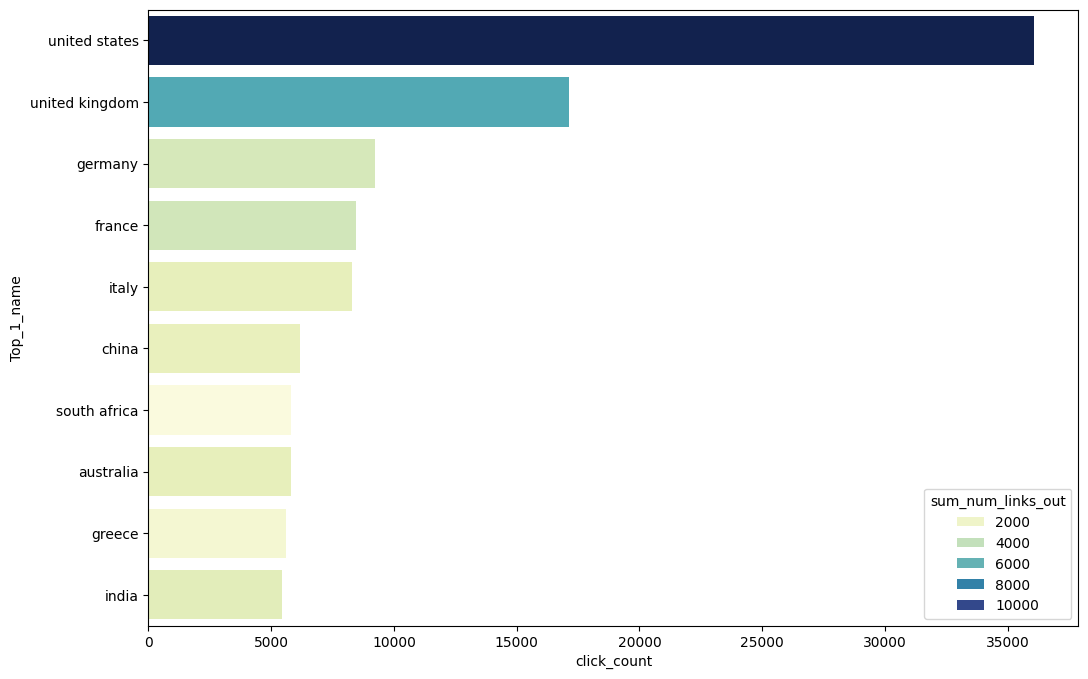

In [27]:
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, i=1)

If we scale by the number of outgoing links, which places all countries at the same scale, we will have a better intuition on which countries player tend to stop playing the game the most 

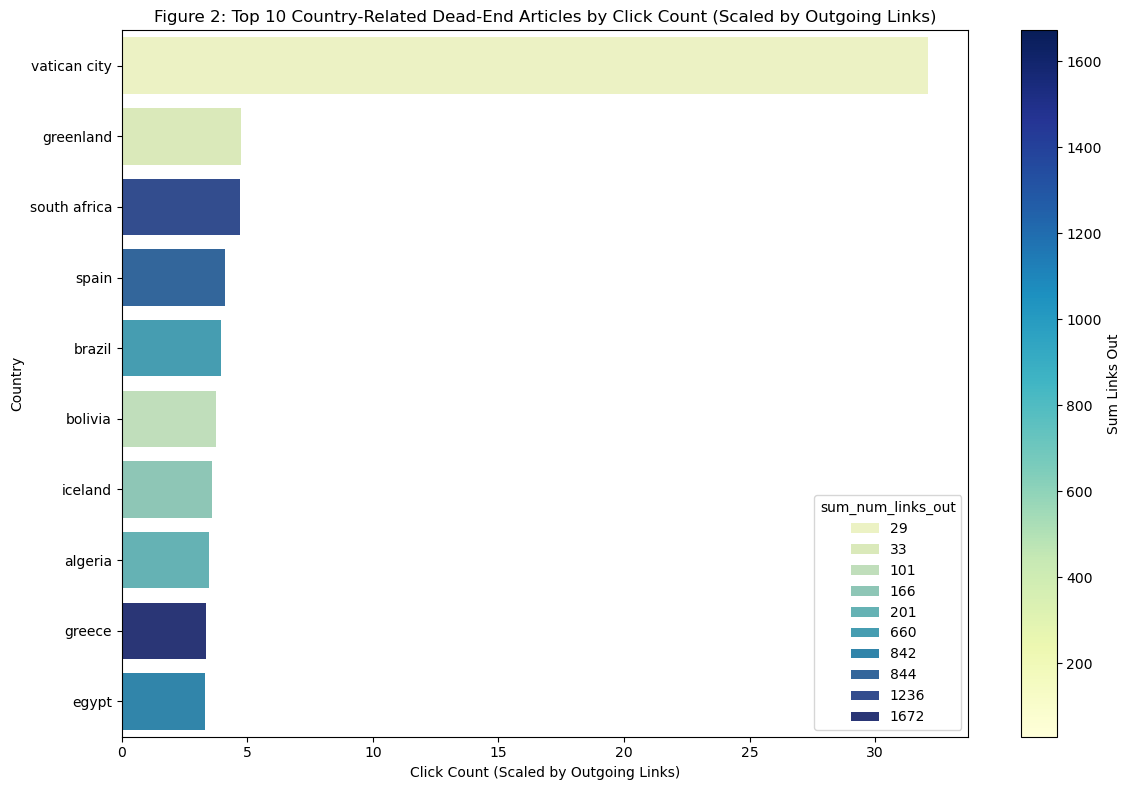

In [ ]:
# Scale the click count by the mean number of outgoing links
unique_dead_end_countries["scaled_click_count"] = unique_dead_end_countries["click_count"] / unique_dead_end_countries["sum_num_links_out"]

# Plot using the updated DataFrame with scaled click count
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, use_scaled=True, i=2)

In [ ]:
import plotly.graph_objects as go

def plot_top_dead_end_countries_plotly(unique_dead_end_countries, top_n=10):
    """
    Plots the top country-related dead-end articles with an interactive button
    to switch between before scaling and after scaling (scaled click counts).
    
    Args:
        unique_dead_end_countries (pd.DataFrame): DataFrame containing dead-end 
                                                  country-related articles with click counts and link information.
        top_n (int): Number of top articles to display (default is 10).
    """
    # Get the top N data for both "before scaling" and "after scaling"
    top_before_scaling = unique_dead_end_countries.sort_values(
        by="click_count", ascending=False
    ).head(top_n)
    top_after_scaling = unique_dead_end_countries.sort_values(
        by="scaled_click_count", ascending=False
    ).head(top_n)
    
    # Create traces for before scaling
    trace_before = go.Bar(
        x=top_before_scaling["click_count"],
        y=top_before_scaling["Top_1_name"],
        orientation="h",
        marker=dict(color=top_before_scaling["sum_num_links_out"], colorscale="YlGnBu"),
        name="Before Scaling",
    )

    # Create traces for after scaling
    trace_after = go.Bar(
        x=top_after_scaling["scaled_click_count"],
        y=top_after_scaling["Top_1_name"],
        orientation="h",
        marker=dict(color=top_after_scaling["sum_num_links_out"], colorscale="YlGnBu"),
        name="After Scaling",
    )

    # Layout with updatemenus (buttons)
    layout = go.Layout(
        title="Top Country-Related Dead-End Articles by Click Count",
        xaxis=dict(title="Click Count"),
        yaxis=dict(title="Country"),
        coloraxis=dict(colorbar_title="Sum Links Out"),
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                x=0.7,
                y=1.2,
                showactive=True,
                buttons=[
                    dict(
                        label="Before Scaling",
                        method="update",
                        args=[
                            {"visible": [True, False]},  # Show first trace
                            {"title": "Top Country-Related Dead-End Articles (Before Scaling)"},
                        ],
                    ),
                    dict(
                        label="After Scaling",
                        method="update",
                        args=[
                            {"visible": [False, True]},  # Show second trace
                            {"title": "Top Country-Related Dead-End Articles (After Scaling)"},
                        ],
                    ),
                ],
            )
        ],
    )

    # Combine traces
    fig = go.Figure(data=[trace_before, trace_after], layout=layout)

    # Initially set visibility
    fig.data[0].visible = True  # Before scaling
    fig.data[1].visible = False  # After scaling

    # Show the interactive plot
    fig.show()
    #fig.write_html('graphs/top_country_dead_end_articles.html')

In [ ]:
plot_top_dead_end_countries_plotly(unique_dead_end_countries, top_n=10)

# 4. Naïve analysis of players click count (Players' Behavior Before Balancing)

Computation of the click count was done using the script `src/scripts/articles_clicks_links.py`, which exports to a CSV file in `data/country_clicks_links`. The first and last articles of each finished path were removed before counting the clicks, as well as the first article for unfinished paths, as they do not truly represent the intentions of the player (they are chosen by the game, not the player). A few articles with wrong number of links were also removed from the dataset (their links seem not to be present in the dataset file `links.tsv`). Those articles are in the `bad_articles` variable in the `articles_clicks_links.py` script.

The first scaling of the click count introduced here is a simple normalization by the number of articles per country. Let $C$ be the set of articles belonging to a given country, then our scaling $s(C)$ is defined as:

$$s(C) = \frac{\sum_{a \in C} c(a)}{|C|}$$

With $c(a)$ the click count of article $a$. This is simply a mean of the click count per article in the country.

As explained in the data story, this does not take into account more complex features of the graph structure, which is why we will introduce more advanced balancing methods to better take into account the graph's confounding effects.

#### Do a basic preprocessing to have the data in the appropriate format

In [28]:
data = pd.read_csv("data/country_clicks_links.csv", index_col=0)
articles = data.index.tolist()
clicks = [f"{data.click_count.iloc[i]} clicks" for i in range(len(articles))]

country_clicks = data.groupby('Top_1_name')['click_count'].sum().reset_index()
top_1_counts = data['Top_1_name'].value_counts()
country_clicks['occurrences'] = country_clicks['Top_1_name'].map(top_1_counts)
country_clicks["scaled_click_count"] = country_clicks["click_count"] / country_clicks["occurrences"]

countries = country_clicks.Top_1_name.tolist()
clicks = country_clicks.click_count.tolist()
clicks_scaled = country_clicks.scaled_click_count.tolist()

finished_paths = load_path_finished_dataframe()
finished_paths_divided = finished_paths["path"].apply(lambda row: row.split(';'))

unfinished_paths = load_path_unfinished_distance_dataframe()
unfinished_paths_divided = unfinished_paths["path"].apply(lambda row: row.split(';'))

#### Compute nodes characteristics (size and color based on the country click count)

In [29]:
# Get the geolocalisation of every country
latitudes, longitudes = geolocalization(country_clicks)

# color of nodes is proportional to the click count
scaler = MinMaxScaler(feature_range=(0.25, 1.5))
normalized_counts = scaler.fit_transform([[count] for count in clicks]).flatten()
color_map = plt.cm.get_cmap('Purples')
colors_hex_before = [matplotlib.colors.to_hex(color_map(norm)) for norm in normalized_counts]

# size of nodes is proportional to the click count 
size_scaler = MinMaxScaler(feature_range=(9, 90))
node_sizes = size_scaler.fit_transform([[count] for count in clicks]).flatten()

Processing countries: 100%|██████████| 195/195 [04:25<00:00,  1.36s/country]
C:\Users\orian\AppData\Local\Temp\ipykernel_29392\3046315152.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



#### Identify highway paths most often used by players

In [30]:
# highway paths will define edges on our maps
# Focus on finished paths first
all_pairs_finished = find_pairs(finished_paths_divided)
all_pairs_finished_df = pd.DataFrame({'1-unit long path': all_pairs_finished})

# Then, focus on unfinished paths
all_pairs_unfinished = find_pairs(unfinished_paths_divided)
all_pairs_unfinished_df = pd.DataFrame({'1-unit long path': all_pairs_unfinished})

# Combine finished and unfinished paths
all_pairs_merged = pd.concat([all_pairs_finished_df, all_pairs_unfinished_df])

# Divide pairs into 2 columns 'From' and 'To' > Split
all_pairs_countries = all_pairs_merged.copy()
all_pairs_countries['Article_from'] = all_pairs_merged['1-unit long path'].apply(lambda row: row[0].split(',')[0] if isinstance(row[0], str) else row)
all_pairs_countries['Article_to'] = all_pairs_merged['1-unit long path'].apply(lambda row: row[1].split(',')[0] if isinstance(row[0], str) else row)

# Associate each article from columns 'From' and 'To' to their Top_1_name country
all_pairs_countries['Top1_country_From'] = all_pairs_countries['Article_from'].map(data['Top_1_name'])
all_pairs_countries['Top1_country_To'] = all_pairs_countries['Article_to'].map(data['Top_1_name'])

# Create a column with a pair of countries
all_pairs_countries['1-unit long path - COUNTRIES'] = all_pairs_countries['Top1_country_From'] + "-> " + all_pairs_countries['Top1_country_To']

# Normalize
all_pairs_countries_normalized = all_pairs_countries["1-unit long path - COUNTRIES"].value_counts() / all_pairs_countries["1-unit long path - COUNTRIES"].value_counts().sum()


#### Map 1 - Before scaling - with Folium library

In [31]:
# Create the world map of the click count per country and game path between countries before scaling
overlap_world_map_clicks_before("world_click_counts_before_scaling.html", clicks, all_pairs_countries_normalized, countries, latitudes,longitudes)

Map is saved in world_click_counts_before_scaling.html!


#### Map 2 - After scaling - with Folium library

In [32]:
# Create the world map of the click count per country and game path between countries after scaling
overlap_world_map_clicks_after("world_click_counts_after_scaling.html", clicks_scaled, all_pairs_countries_normalized, countries, latitudes,longitudes)

Map is saved in world_click_counts_after_scaling.html!


# 5. Accounting for the influence of the graph's structure

As explained in the story, a propensity score matching approach is not feasible due to the high number of groups that we compare (one group per country, so 249 groups), and also due to the fact that some countries are only made up of a few (1 or 2) articles. Our simpler approach then consists of normalizing the total click counts of a country by the sum of links-in from articles in that country. Let $C$ be the set of articles in a given country, then our new normalized click count metric $n(C)$ will be:

$$ n(C) = \frac{\sum_{a \in C} c(a)}{\sum_{a \in C} d_{in}(a)} $$

With $c(a)$ the click count of an article $a$, $d_{in}(a)$ the in-degree of an article $a$.

Below you will find the code for computing that metric

In [11]:
countries = normalize_clicks()
countries.head()

,Top_1_name,num_links_in,click_count,click_count_normalized
0,afghanistan,313.0,629,2.009585
1,albania,85.0,21,0.247059
2,algeria,263.0,700,2.661597
3,andorra,41.0,6,0.146341
4,angola,80.0,28,0.350000


#### Visualisation of the click count after normalization

In [ ]:

click_count_normalized = countries['click_count_normalized'].tolist()
countries_names = countries.Top_1_name.tolist()
latitudes, longitudes = geolocalization(countries)
overlap_world_map_normalized_clicks("./graphs/normalized_click_counts.html", click_count_normalized, countries_names, latitudes,longitudes)

Processing countries: 100%|██████████| 195/195 [03:54<00:00,  1.21s/country]

Map is saved in normalized_click_counts.html!


## 5.1 PageRank analysis

### Running PageRank
First, let us the PageRank algorithm on the Wikipedia graph. We use a helper function for this that takes as input the edges from the Wikipedia graph, that is the links dataframe.

In [35]:
links_df = load_links_dataframe()
df_pagerank = pagerank(links_df)
df_pagerank.head()

,article_name,rank
0,United_States,0.009567
1,France,0.006421
2,Europe,0.006340
3,United_Kingdom,0.006230
4,English_language,0.004861


### Computing players rank based on their click counts
Next, we will compute a rank similar to that of PageRank, but based on the click counts of the players. For each article $a$, we define its rank as:
$$r(a) = \frac{c(a)}{\sum_{a' \in A}{c(a')}}$$
where
* $c(a)$ is the click count of the article $a$ (the number of times it appears in the recorded player paths)
* $A$ is the set of all articles in the Wikipedia graph
With this definition we have that $ 0 \le r(a) \le 1 \hspace{2mm} \forall a$ and $\sum_{a \in A}{r(a)} = 1$ which are the properties necessary to compare our ranks with PageRank.

In [36]:
df_player_frequencies = compute_player_frequencies()

df_player_frequencies.head()

,article_name,rank
0,United_States,0.039275
1,Europe,0.017631
2,United_Kingdom,0.016758
3,England,0.013665
4,Earth,0.013125


Let us first plot a raw comparison of the top 40 PageRank articles and the associated players rank

We then aggregate ranks by country. Let C be the set of articles in a given country. We define the rank of a country $r(C)$ as:
$$r(C) = \sum_{a \in C} r(a)$$

To do that, we associate each article with its country using the assignment described in part 1.

In [37]:
article_to_countries = pd.read_csv('data/country_data_full_llama_improved.csv', index_col=0)[['Top_1_name']].rename(columns={'Top_1_name': 'country_name'})
article_to_countries.index.name = 'article_name'
article_to_countries.reset_index(inplace=True)

df_player_frequencies = pd.merge(df_player_frequencies, article_to_countries, on='article_name')
df_pagerank = pd.merge(df_pagerank, article_to_countries, on='article_name')

df_player_frequencies_country = aggregate_ranks_by_country(df_player_frequencies)
df_pagerank_country = aggregate_ranks_by_country(df_pagerank)

df_player_frequencies_country.head()

,country_name,rank
0,afghanistan,0.001997
1,albania,0.000067
2,algeria,0.002223
3,andorra,0.000019
4,angola,0.000089


### Visualisation of the countries by page rank and player rank

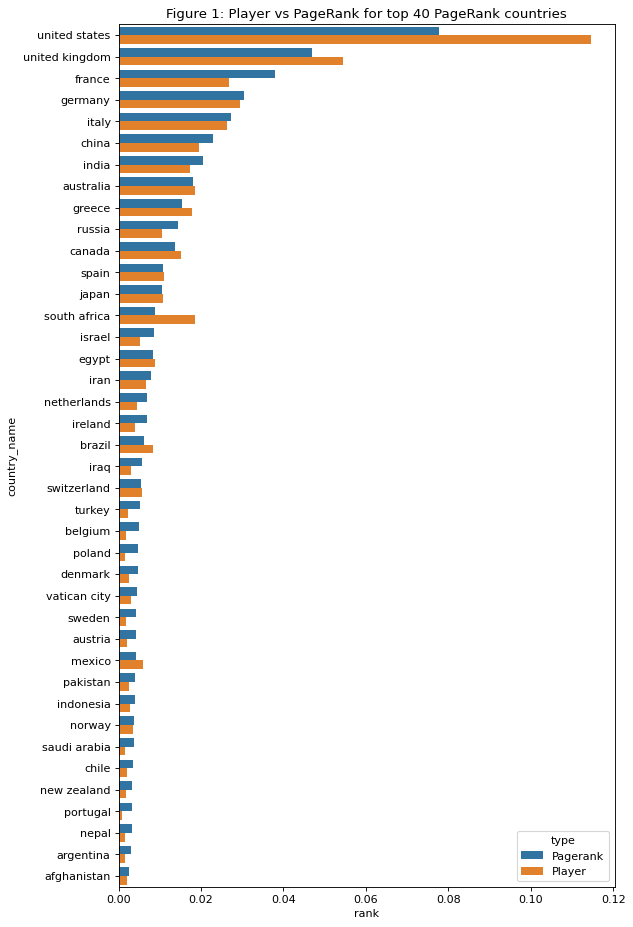

In [47]:
top_player_vs_pagerank_country_frequencies(df_player_frequencies_country, df_pagerank_country)

### Computing rank difference
To investigate further, we will compute the difference between the players rank and the pageranks.

In [45]:
rank_v_freq_countries = rank_diff(
    df_pagerank,
    df_player_frequencies
)
rank_v_freq_countries.head()

,country_name,rank_pagerank,rank_players,rank_diff
0,NaN,0.412083,0.480578,0.068496
1,united states,0.077690,0.114548,0.036858
2,united kingdom,0.046841,0.054451,0.007611
3,france,0.037857,0.026911,-0.010945
4,germany,0.030408,0.029350,-0.001058


Let us see how the difference looks like further in the articles list. To do that, we plot the PageRanks and players ranks for all articles, sorted by PageRank. For comparison, we do the same with country aggregates.

Note: here `NaN` represents articles with no linked countries. We see that they make up for about 40% of the PageRank! However those articles are discarded in our analysis since we concentrate on country biases.

### Visualisation of the rank difference

Text(0.5, 0.98, 'Figure 2')

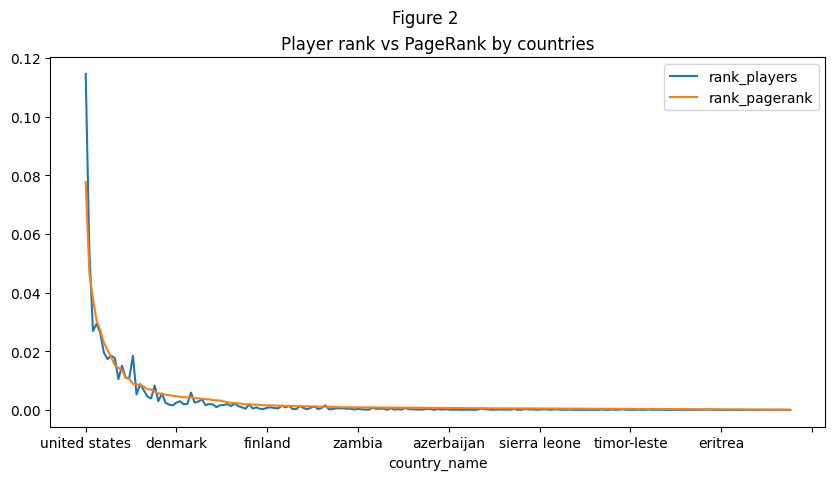

In [48]:
fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(10)

ax1.set_title('Player rank vs PageRank by countries')
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_players', ax=ax1)
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_pagerank', ax=ax1)
plt.suptitle("Figure 2")

### High difference countries
Now we will have a look at which countries have the highest difference with respect to PageRank. To do this we sort the differences aggregated by countries from higher to lower values, and then analyze the countries with the highest positive difference (players tend to go more often to them than random walk), and highest negative difference (players tend to go less often to them than random walk)

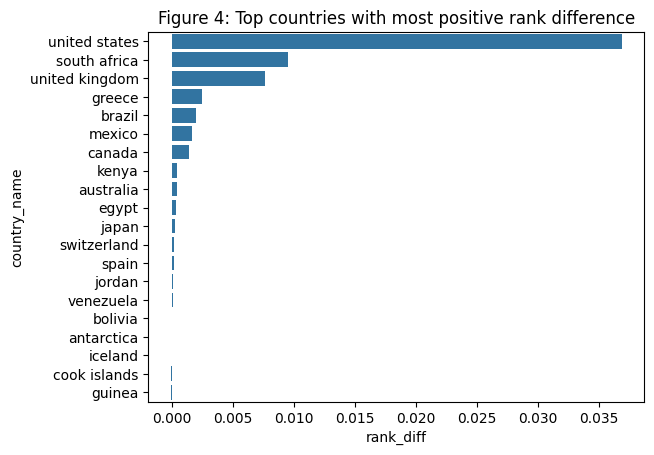

In [42]:
rank_v_freq_by_diff = rank_v_freq_countries.dropna().sort_values(by='rank_diff', ascending=False)
sns.barplot(rank_v_freq_by_diff.head(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 4: Top countries with most positive rank difference")
plt.show()

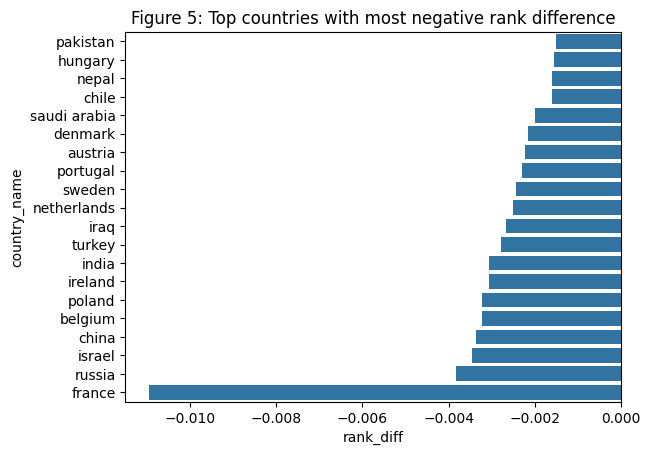

In [43]:
sns.barplot(rank_v_freq_by_diff.tail(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 5: Top countries with most negative rank difference")
plt.show()

### Statistical significance
Lastly, to make sure our conclusions are valid, let us see if the difference in the players behavior is statistically significant. To do that, we compute a chi-square test with the null hypothesis that players rank and PageRank come from the same multinomial distribution. The number of trials (parameter $n$ of the distribution) is set to the total number of clicks in the game.

In [49]:
from scipy.stats import chisquare
# p-value for significance of divergence in distribution
df_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
total_number_of_clicks = df_clicks['click_count'].sum()
chisquare(rank_v_freq_countries['rank_players'] * total_number_of_clicks, rank_v_freq_countries['rank_pagerank'] * total_number_of_clicks)

Power_divergenceResult(statistic=36765.44945735122, pvalue=0.0)

Given that the p-value is very close to 0 (floating point has approximated it to 0), we can conclude that the players behave significantly differently than a random walk. Although they are not particularly biased towards all Western countries, they seem to be biased toward english speaking countries.